<a href="https://colab.research.google.com/github/AbderrhmanAbdellatif/CRM/blob/master/Customer%20Lifetime%20Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Calculating Lifetime Value is the easy part. First we need to select a time window. It can be anything like 3, 6, 12, 24 months. By the equation below, we can have Lifetime Value for each customer in that specific time window:

### Lifetime Value: Total Gross Revenue - Total Cost    >> ne demek istemis , Total Gross Revenue nedir ,   Total Cost nedir

### This equation now gives us the historical lifetime value. If we see some customers having very high negative lifetime value historically, it could be too late to take an action. At this point, we need to predict the future with machine learning:

In [2]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
#import machine learning related libraries
from sklearn.svm import SVC 
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import plotly.offline as pyoff
import plotly.graph_objs as go
import xgboost as xgb
import datetime as dt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import ClassificationReport
import xgboost as xgb
#initate plotly
pyoff.init_notebook_mode()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [3]:
#read data from csv and redo the data work we done before
tx_data = pd.read_csv('https://raw.githubusercontent.com/AbderrhmanAbdellatif/CRM/master/OnlineRetail.csv',encoding= 'unicode_escape')
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_uk.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

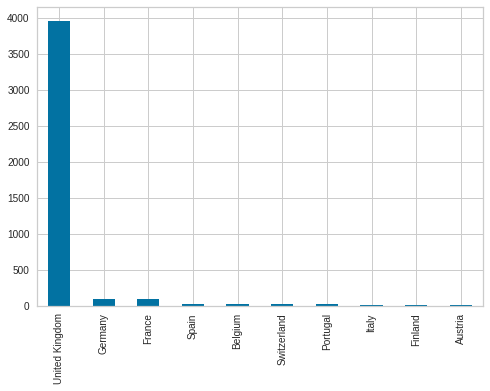

In [4]:
filtered_data=tx_data[['Country','CustomerID']].drop_duplicates()
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [5]:
uk_data = tx_data.describe()[(tx_data.describe()['Quantity']>0)]
uk_data=tx_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']
uk_data['InvoiceDate'].min(),uk_data['InvoiceDate'].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [6]:
PRESENT = dt.datetime(2011,12,10)
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])
uk_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CustomerID         InvoiceDate InvoiceNo  Quantity  UnitPrice  TotalPrice
0     17850.0 2010-12-01 08:26:00    536365         6       2.55       15.30
1     17850.0 2010-12-01 08:26:00    536365         6       3.39       20.34
2     17850.0 2010-12-01 08:26:00    536365         8       2.75       22.00
3     17850.0 2010-12-01 08:26:00    536365         6       3.39       20.34
4     17850.0 2010-12-01 08:26:00    536365         6       3.39       20.34

In [0]:
rfm= uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [8]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [9]:
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm.head()

recency  frequency  monetary
CustomerID                              
12346.0         325          2      0.00
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          18         73   1757.55
12350.0         310         17    334.40

{1: 295575030383.9552,
 2: 100276008248.96974,
 3: 49416897311.26088,
 4: 30433058064.427795,
 5: 18026242303.76365,
 6: 11821248343.350105,
 7: 8610724210.444056,
 8: 5663435723.215929,
 9: 4217222416.610691,
 10: 3291222238.626194}

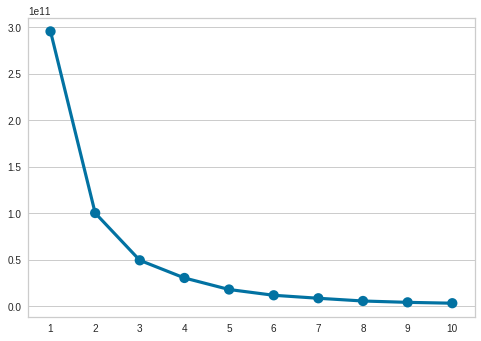

In [10]:
wcss = {}
for k in range(1,11):#30 adet orenklerememiz oldugu icin 1'den 30'a kadar gitmesini sagliyoruz
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm)# standartlastirdigimi datamiza gore fit et, yani modelimizi olustur.
    wcss[k] = kmeans.inertia_#inertia ne demek ? her bir k degeri icin wcss degerini bul  
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
wcss


Müşterilerimizi segmentlere ayırdık ve kimin en iyisi olduğunu öğrendik. Şimdi yakından izlememiz gereken en önemli metriklerden birini ölçme zamanı: 
**Müşteri Yaşam Boyu Değeri**

Gelir elde etmek ve kârlı olmak için müşterilere (edinme maliyetleri, çevrimdışı reklamlar, promosyonlar, indirimler vb.) Yatırım yapıyoruz. Doğal olarak, bu eylemler bazı müşterileri yaşam boyu değer açısından süper değerli kılar, ancak her zaman karlılığı azaltan bazı müşteriler vardır. Bu davranış kalıplarını tanımlamamız, müşterileri segmentlere ayırmamız ve buna göre hareket etmemiz gerekiyor.


Yaşam Boyu Değerin hesaplanması kolay bir parçadır. İlk önce bir zaman penceresi seçmeliyiz. 3, 6, 12, 24 ay gibi bir şey olabilir. Aşağıdaki denklemle, belirli bir zaman penceresinde her müşteri için Yaşam Boyu Değere sahip olabiliriz:


**Ömür Boyu Değer**: Toplam Brüt Gelir - Toplam Maliyet

Bu denklem şimdi bize tarihsel yaşam boyu değer veriyor. Tarihsel olarak çok yüksek negatif yaşam boyu değere sahip bazı müşteriler görürsek, harekete geçmek için çok geç olabilir. Bu noktada, makine öğrenimi ile geleceği tahmin etmemiz gerekiyor 
**Müşterilerimizin yaşam boyu değerlerini tahmin eden basit bir makine öğrenimi modeli oluşturacağız.**

##Yaşam Boyu Değer Tahmini

*   Müşteri Yaşam Boyu Değer hesaplaması için uygun bir zaman dilimi tanımlayın
*   Geleceği tahmin etmek ve yaratmak için kullanacağımız özellikleri belirleyin
*   Makine öğrenimi modelini eğitmek için yaşam boyu değeri (YBD) hesapla
*   Makine öğrenimi modelini oluşturun ve çalıştırın
*   Modelin faydalı olup olmadığını kontrol edin


Zaman aralığına karar vermek sektörünüze, iş modelinize, stratejinize ve daha fazlasına bağlıdır. Bazı endüstriler için, 1 yıl çok uzun bir dönem iken, diğerleri için çok kısadır. Örneğimizde 6 ay ile devam edeceğiz 


Her bir müşteri kimliği için **RFM puanları** özellik kümesi için mükemmel adaylardır. Doğru bir şekilde uygulamak için veri kümemizi ayırmamız gerekir. 3 aylık veri alacağız, RFM'yi hesaplayacağız ve önümüzdeki 6 ayı tahmin etmek için kullanacağız. Bu yüzden önce iki veri çerçevesi oluşturmalı ve onlara RFM puanları eklemeliyiz.

# Create 3m and 6m dataframes

In [11]:
tx_3m = tx_uk[(tx_uk.InvoiceDate < datetime(2011,6,1)) & (tx_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
tx_3m.head()

InvoiceNo StockCode  ... CustomerID         Country
0    545220     21955  ...    14620.0  United Kingdom
1    545220     48194  ...    14620.0  United Kingdom
2    545220     22556  ...    14620.0  United Kingdom
3    545220     22139  ...    14620.0  United Kingdom
4    545220    84029G  ...    14620.0  United Kingdom

[5 rows x 8 columns]

In [12]:
tx_6m = tx_uk[(tx_uk.InvoiceDate >= datetime(2011,6,1)) & (tx_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)
tx_6m.head()

InvoiceNo StockCode  ... CustomerID         Country
0    555156     23299  ...    15643.0  United Kingdom
1    555156     22847  ...    15643.0  United Kingdom
2    555157     23075  ...    15643.0  United Kingdom
3    555157    47590B  ...    15643.0  United Kingdom
4    555157     22423  ...    15643.0  United Kingdom

[5 rows x 8 columns]

In [13]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

CustomerID
0     14620.0
1     14740.0
2     13880.0
3     16462.0
4     17068.0

#Cluster Method

# Order cluster method

In [0]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

# calculate recency score

In [0]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [17]:
tx_user.head()

CustomerID  Recency  RecencyCluster
0     14620.0       12               3
1     14740.0        4               3
2     17068.0       11               3
3     12971.0        4               3
4     15194.0        6               3

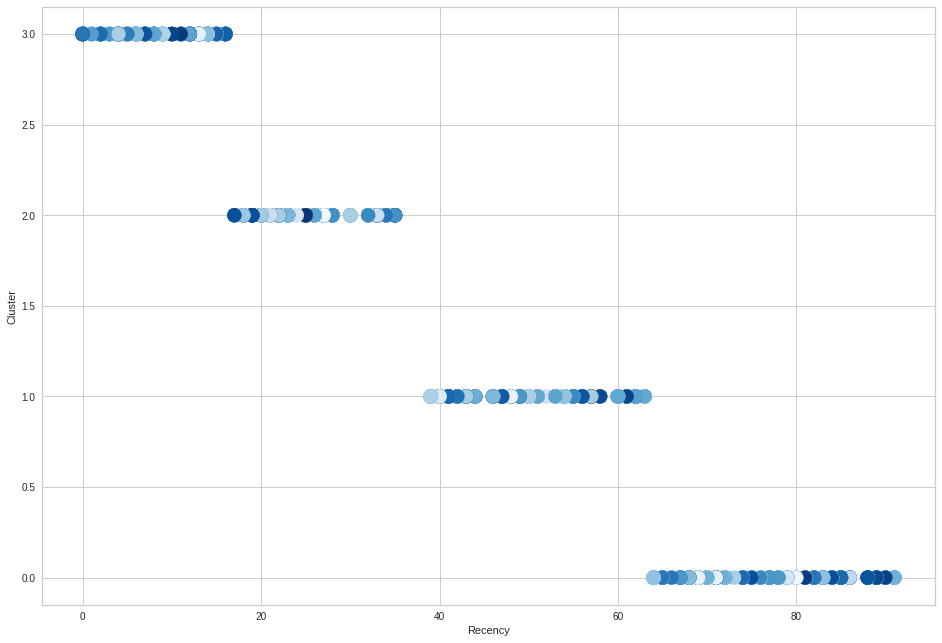

In [18]:
plt.scatter(tx_user['Recency'],tx_user['RecencyCluster'],c=tx_user['CustomerID'],s=200,cmap='Blues')
plt.xlabel('Recency')
plt.ylabel('Cluster')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.show()

In [19]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

count       mean       std   min   25%   50%   75%   max
RecencyCluster                                                          
0               349.0  76.885387  8.373023  64.0  70.0  76.0  84.0  91.0
1               439.0  50.020501  7.377743  39.0  43.0  49.0  56.0  63.0
2               444.0  24.373874  4.959870  17.0  20.0  23.0  27.0  35.0
3               608.0   8.312500  4.404323   0.0   5.0   8.0  12.0  16.0

# calcuate frequency score

In [0]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [22]:
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster
0     14620.0       12               3         30                 0
1     15194.0        6               3         64                 0
2     18044.0        5               3         57                 0
3     18075.0       12               3         35                 0
4     15241.0        0               3         64                 0

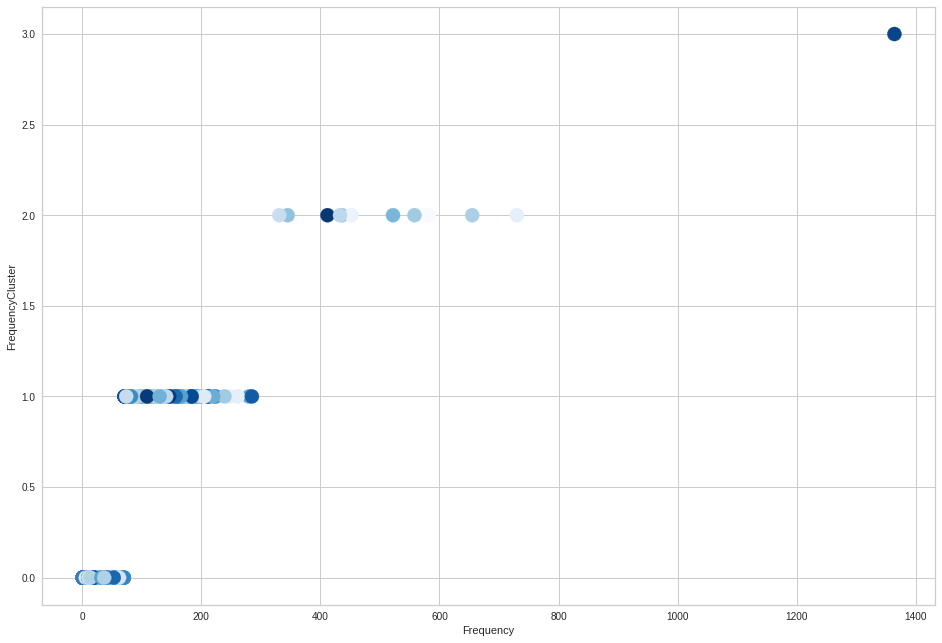

In [23]:
plt.scatter(tx_user['Frequency'],tx_user['FrequencyCluster'],c=tx_user['CustomerID'],s=200,cmap='Blues')
plt.xlabel('Frequency')
plt.ylabel('FrequencyCluster')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.show()

In [24]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

count         mean         std  ...     50%     75%     max
FrequencyCluster                                   ...                        
0                 1605.0    24.218069   17.761893  ...    20.0    36.0    70.0
1                  223.0   116.560538   43.816927  ...   104.0   131.5   285.0
2                   11.0   496.000000  125.912668  ...   452.0   570.0   730.0
3                    1.0  1364.000000         NaN  ...  1364.0  1364.0  1364.0

[4 rows x 8 columns]

## calcuate revenue score


In [0]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [26]:
tx_user.Revenue.describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: Revenue, dtype: float64

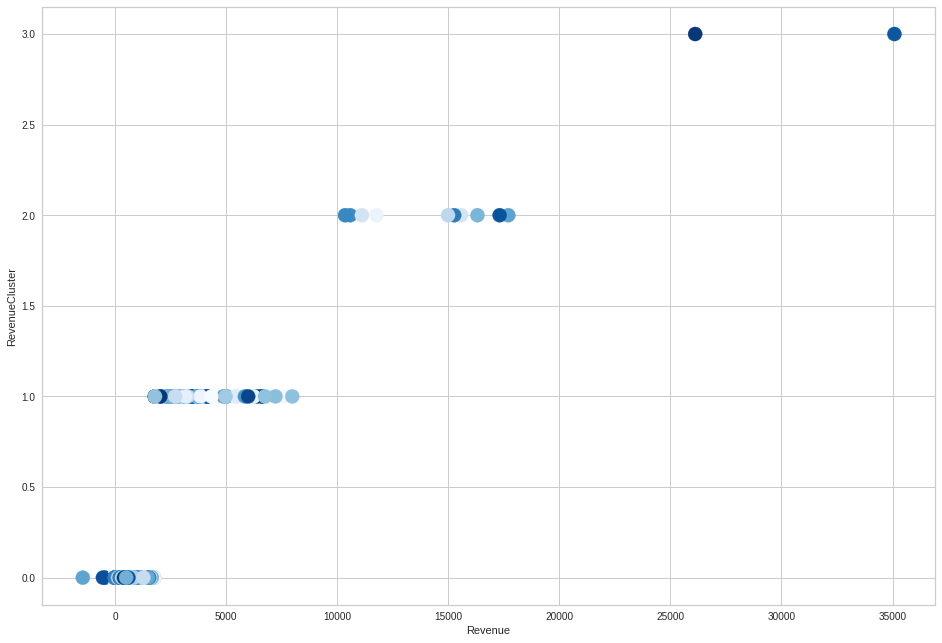

In [27]:
plt.scatter(tx_user['Revenue'],tx_user['RevenueCluster'],c=tx_user['CustomerID'],s=200,cmap='Blues')
plt.xlabel('Revenue')
plt.ylabel('RevenueCluster')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.show()

In [28]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

count          mean  ...         75%       max
RevenueCluster                        ...                      
0               1714.0    469.943256  ...    626.8900   1763.04
1                114.0   3084.445096  ...   3483.3075   7969.99
2                 10.0  14092.686000  ...  16124.8250  17700.64
3                  2.0  30599.645000  ...  32842.5625  35085.48

[4 rows x 8 columns]

In [0]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [30]:
tx_user

CustomerID  Recency  ...  OverallScore     Segment
0        14620.0       12  ...             3   Mid-Value
1        15194.0        6  ...             3   Mid-Value
2        18044.0        5  ...             3   Mid-Value
3        18075.0       12  ...             3   Mid-Value
4        15241.0        0  ...             3   Mid-Value
...          ...      ...  ...           ...         ...
1835     17511.0       14  ...             6  High-Value
1836     16684.0       13  ...             6  High-Value
1837     15311.0        4  ...             7  High-Value
1838     13089.0        5  ...             7  High-Value
1839     14298.0       27  ...             6  High-Value

[1840 rows x 9 columns]

In [31]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Recency   Frequency       Revenue
OverallScore                                     
0             77.009009   18.441441    286.345465
1             50.990476   24.476190    370.358286
2             26.614833   30.765550    493.844187
3             10.329897   36.298969    616.318495
4              8.850877   96.456140   1990.659219
5              6.529412  121.509804   3288.066863
6              7.625000  329.125000  10894.470000
7              3.000000  779.333333  11350.896667

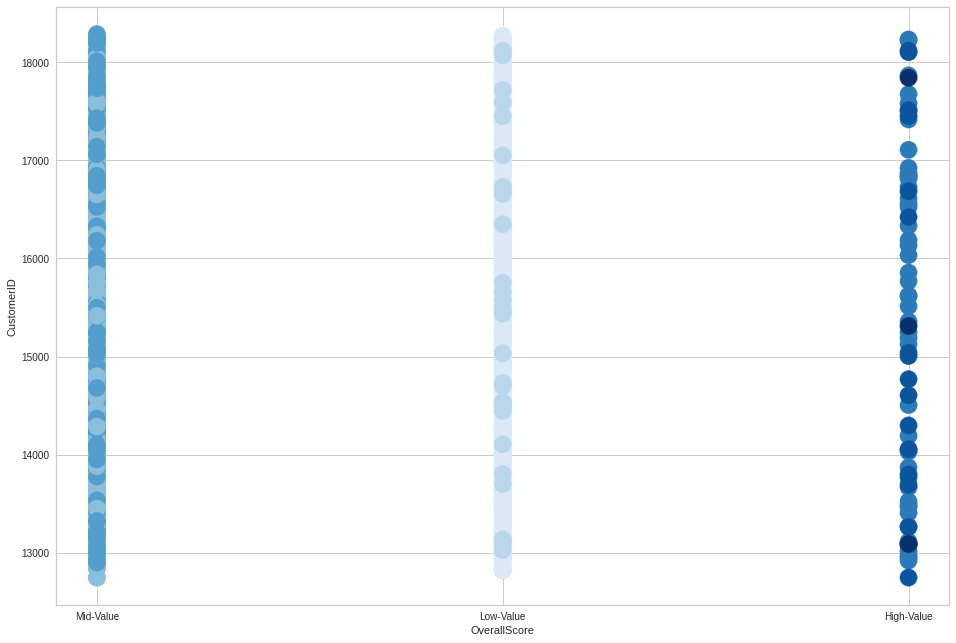

In [32]:
plt.scatter(tx_user['Segment'],tx_user['CustomerID'],c=tx_user['OverallScore'],s=300,cmap='Blues')
plt.xlabel('OverallScore')
plt.ylabel('CustomerID')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.show()

In [33]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    333
1    420
2    418
3    485
4    114
5     51
6     16
7      3
Name: Recency, dtype: int64

## calculate revenue and create a new dataframe for it

In [0]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

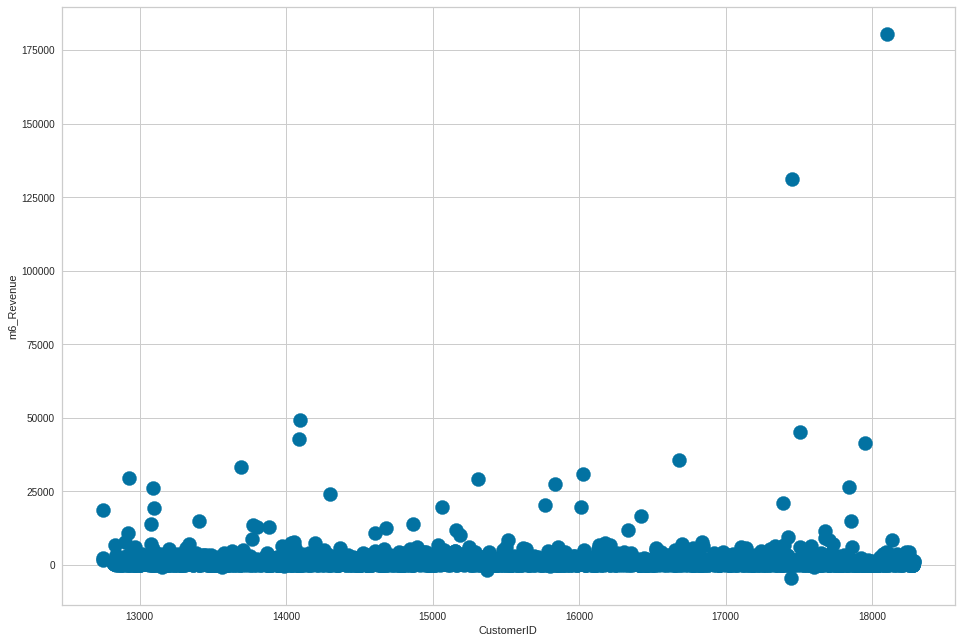

In [35]:
plt.scatter(tx_user_6m['CustomerID'],tx_user_6m['m6_Revenue'],s=200,cmap='Blues')
plt.xlabel('CustomerID')
plt.ylabel('m6_Revenue')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.show()

![alt text](https://miro.medium.com/max/1400/1*3w0sJSAFCRQjhGKSG7ICYg.png)

### Histogram clearly shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

# We will merge our 3 months and 6 months dataframes to see correlations between LTV and the feature set we have.

In [0]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [37]:
tx_merge.head()

CustomerID  Recency  RecencyCluster  ...  OverallScore    Segment  m6_Revenue
0     14620.0       12               3  ...             3  Mid-Value         NaN
1     15194.0        6               3  ...             3  Mid-Value     3232.20
2     18044.0        5               3  ...             3  Mid-Value      991.54
3     18075.0       12               3  ...             3  Mid-Value     1322.75
4     15241.0        0               3  ...             3  Mid-Value      791.04

[5 rows x 10 columns]

In [0]:
tx_graph = tx_merge.query("m6_Revenue < 30000")

In [39]:
tx_graph.head()

CustomerID  Recency  RecencyCluster  ...  OverallScore    Segment  m6_Revenue
1     15194.0        6               3  ...             3  Mid-Value     3232.20
2     18044.0        5               3  ...             3  Mid-Value      991.54
3     18075.0       12               3  ...             3  Mid-Value     1322.75
4     15241.0        0               3  ...             3  Mid-Value      791.04
5     15660.0        4               3  ...             3  Mid-Value      858.09

[5 rows x 10 columns]

özellik setimizi ve LTV verilerimizi birleştirir ve LTV ile genel RFM skorunu çizer

No handles with labels found to put in legend.


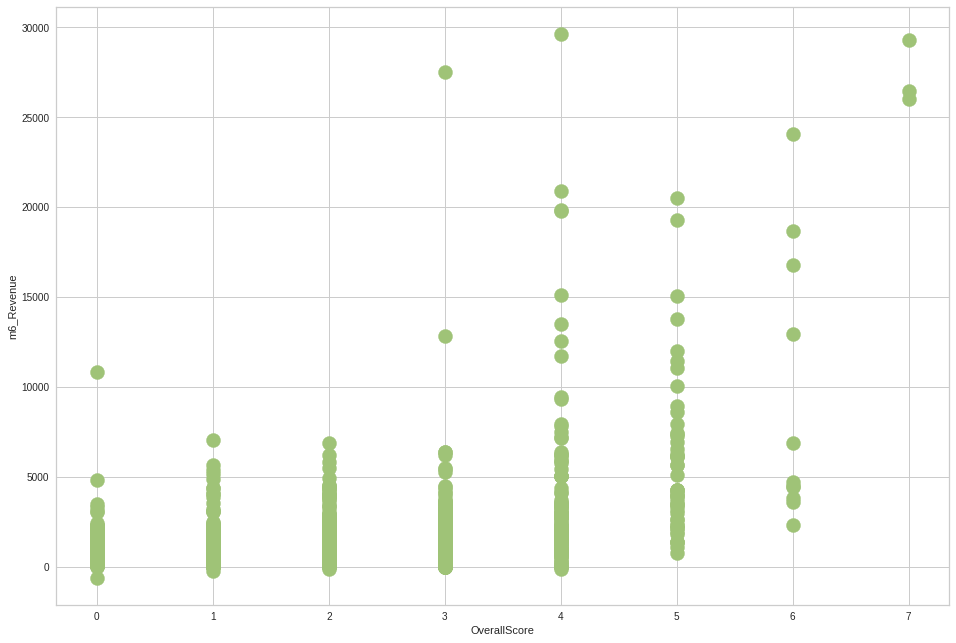

In [40]:
plt.scatter(tx_graph['OverallScore'],tx_graph['m6_Revenue'], c="g",s=200)
plt.xlabel('OverallScore')
plt.ylabel('m6_Revenue')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.legend(loc='upper left')
plt.show()

![alt text](https://miro.medium.com/max/1400/1*TTdNY2WV4n2yr_0IGD8bJA.png)

# The code below merges our feature set and LTV data and plots LTV vs overall RFM score:

Pozitif korelasyon burada oldukça görünür. Yüksek RFM puanı yüksek LTV anlamına gelir.

Makine öğrenimi modelini oluşturmadan önce, bu makine öğrenimi sorununun türünü belirlememiz gerekir. LTV'nin kendisi bir gerileme problemidir. Bir makine öğrenimi modeli LTV'nin $ değerini tahmin edebilir. Ancak burada LTV segmentleri istiyoruz. Çünkü diğer insanlarla iletişim kurmayı daha eyleme geçirilebilir ve kolay hale getirir. K-araçları kümelemesi uygulayarak, mevcut LTV gruplarımızı belirleyebilir ve bunun üzerine segmentler oluşturabiliriz.

In [0]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [42]:
tx_merge.head()

CustomerID  Recency  RecencyCluster  ...  OverallScore    Segment  m6_Revenue
1     15194.0        6               3  ...             3  Mid-Value     3232.20
2     18044.0        5               3  ...             3  Mid-Value      991.54
3     18075.0       12               3  ...             3  Mid-Value     1322.75
4     15241.0        0               3  ...             3  Mid-Value      791.04
5     15660.0        4               3  ...             3  Mid-Value      858.09

[5 rows x 10 columns]

{1: 6288514774.946073,
 2: 2517132265.024306,
 3: 1122136129.0141993,
 4: 657471183.9640551,
 5: 445740258.5938903,
 6: 274630233.9706025,
 7: 203063564.09897965,
 8: 155575926.93719578,
 9: 123266484.88920356,
 10: 103100318.57845685}

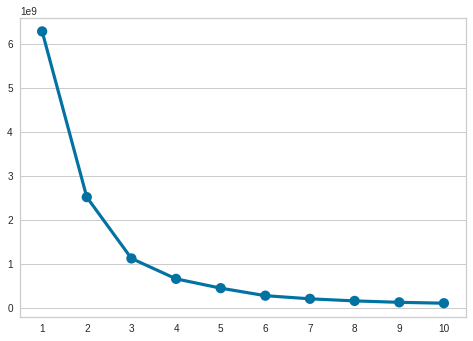

In [43]:
wcss = {}
for k in range(1,11):#30 adet orenklerememiz oldugu icin 1'den 30'a kadar gitmesini sagliyoruz
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(tx_merge[['m6_Revenue']])# standartlastirdigimi datamiza gore fit et, yani modelimizi olustur.
    wcss[k] = kmeans.inertia_#inertia ne demek ? her bir k degeri icin wcss degerini bul  
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
wcss

**Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with, other people. By applying K-means clustering,**

**we can identify our existing LTV groups and build segments on top of it.Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments**

`(number of segments really depends on your business dynamics and goals):`


```
*   Low LTV
*   Mid LTV
*   High LTV

```



**We are going to apply K-means clustering to decide segments and observe their characteristics:**

In [0]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [45]:
tx_merge.head()

CustomerID  Recency  RecencyCluster  ...    Segment  m6_Revenue  LTVCluster
1     15194.0        6               3  ...  Mid-Value     3232.20           0
2     18044.0        5               3  ...  Mid-Value      991.54           2
3     18075.0       12               3  ...  Mid-Value     1322.75           2
4     15241.0        0               3  ...  Mid-Value      791.04           2
5     15660.0        4               3  ...  Mid-Value      858.09           2

[5 rows x 11 columns]

In [46]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)
tx_merge

CustomerID  Recency  RecencyCluster  ...     Segment  m6_Revenue  LTVCluster
0        15194.0        6               3  ...   Mid-Value     3232.20           1
1        13599.0        6               3  ...   Mid-Value     2799.12           1
2        14292.0        5               3  ...   Mid-Value     3313.75           1
3        17017.0        7               3  ...   Mid-Value     3526.64           1
4        14057.0        6               3  ...   Mid-Value     3541.43           1
...          ...      ...             ...  ...         ...         ...         ...
1372     12748.0        0               3  ...  High-Value    18679.01           2
1373     16333.0        0               3  ...  High-Value    11992.40           2
1374     15769.0        5               3  ...  High-Value    20530.00           2
1375     16422.0        4               3  ...  High-Value    16756.31           2
1376     13798.0        4               3  ...  High-Value    12913.99           2

[1377 rows x 11 columns]

No handles with labels found to put in legend.


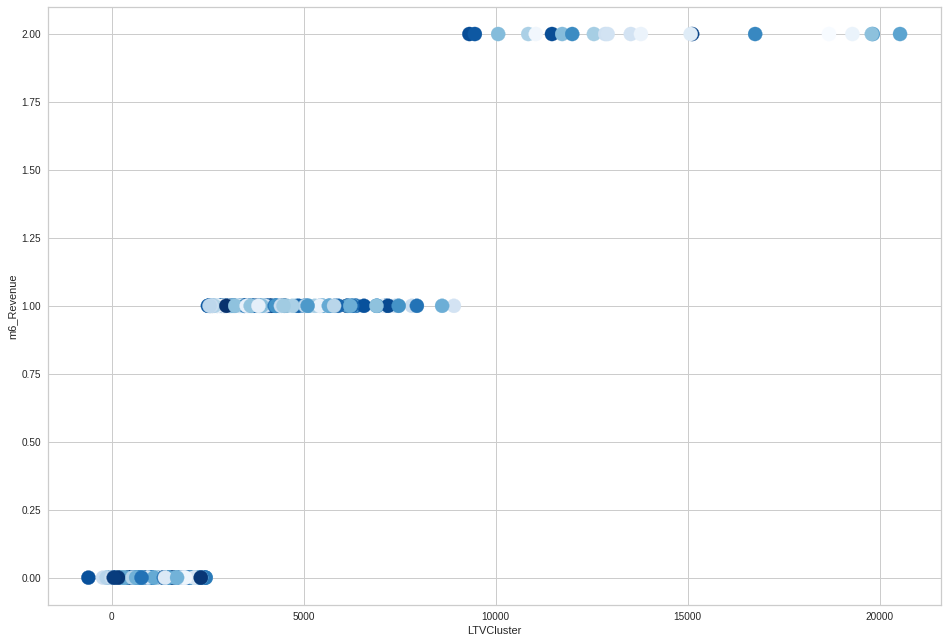

In [47]:
plt.scatter(tx_merge['m6_Revenue'],tx_merge['LTVCluster'],c=tx_merge['CustomerID'],s=200,cmap='Blues')
plt.xlabel('LTVCluster')
plt.ylabel('m6_Revenue')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.legend(loc='upper left')
plt.show()

In [48]:
#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()
#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

count          mean          std  ...        50%        75%       max
LTVCluster                                     ...                                
0           1170.0    828.670189   621.405282  ...    663.525   1245.465   2447.57
1            186.0   4137.019892  1477.396388  ...   3635.200   4987.535   8910.04
2             21.0  14123.309048  3653.311262  ...  12913.990  16756.310  20530.00

[3 rows x 8 columns]

### We have finished LTV clustering and here are the characteristics of each clusters


##Makine öğrenimi modelini eğitmeden önce birkaç adım daha var:


* Bazı özellik mühendisliği yapmak gerekiyor. Kategorik sütunları sayısal sütunlara dönüştürmeliyiz.

* Özelliklerin etiketimiz olan LTV kümeleriyle korelasyonunu kontrol edeceğiz.

*  Özellik setimizi ve etiketimizi (LTV) X ve y olarak böleriz. X'i y'yi tahmin etmek için kullanırız.

*  Eğitim ve Test veri kümesi oluşturur. Makine öğrenme modelinin oluşturulması için eğitim seti kullanılacaktır. Modelimizi gerçek performansını görmek için Test setine uygulayacağız.




İlk satırdan başlayalım. get_dummies () yöntemi, kategorik sütunları 0–1 gösterime dönüştürür. Örnekle tam olarak ne yaptığını görün:

In [0]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

In [50]:
tx_merge.head()

CustomerID  Recency  RecencyCluster  ...    Segment  m6_Revenue  LTVCluster
0     15194.0        6               3  ...  Mid-Value     3232.20           1
1     13599.0        6               3  ...  Mid-Value     2799.12           1
2     14292.0        5               3  ...  Mid-Value     3313.75           1
3     17017.0        7               3  ...  Mid-Value     3526.64           1
4     14057.0        6               3  ...  Mid-Value     3541.43           1

[5 rows x 11 columns]

Bu get_dummies () öncesindeki veri setimizdi. Segment olan bir kategorik sütunumuz var. Get_dummies () uygulandıktan sonra ne olur:

In [51]:
tx_class.head()

CustomerID  Recency  ...  Segment_Low-Value  Segment_Mid-Value
0     15194.0        6  ...                  0                  1
1     13599.0        6  ...                  0                  1
2     14292.0        5  ...                  0                  1
3     17017.0        7  ...                  0                  1
4     14057.0        6  ...                  0                  1

[5 rows x 13 columns]

Segment sütunu gitti, ancak onu temsil eden yeni sayısal sütunlarımız var. 0 ve 1 ile 3 farklı sütuna dönüştürdük ve makine öğrenme modelimiz için kullanılabilir hale getirdik.

###calculate and show correlations


In [0]:
corr_matrix = tx_class.corr()

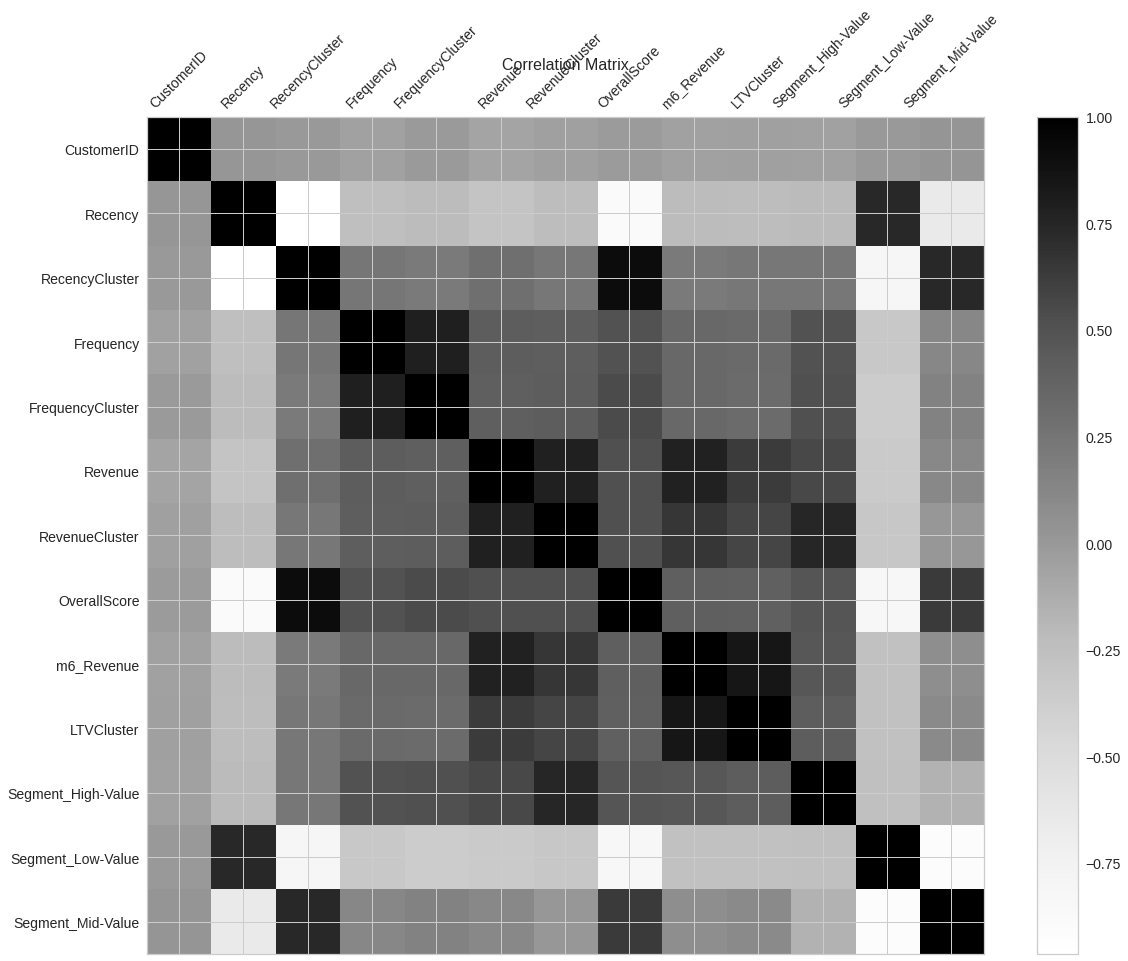

In [53]:
corr_matrix #gorsel yap 
from matplotlib import pyplot
from pandas import read_csv
import numpy
names = ['CustomerID'	,'Recency',	'RecencyCluster',	'Frequency'	,'FrequencyCluster','Revenue','RevenueCluster','OverallScore','m6_Revenue','LTVCluster','Segment_High-Value','Segment_Low-Value','Segment_Mid-Value']
correlations = tx_class.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(correlations, fignum=f.number)
plt.xticks(range(correlations.shape[1]), correlations.columns, fontsize=14, rotation=45)
plt.yticks(range(correlations.shape[1]), correlations.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [54]:
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.848658
Revenue               0.627169
RevenueCluster        0.576323
Segment_High-Value    0.421146
OverallScore          0.397801
Frequency             0.327572
FrequencyCluster      0.323536
RecencyCluster        0.228957
Segment_Mid-Value     0.098534
CustomerID           -0.049691
Recency              -0.228823
Segment_Low-Value    -0.269897
Name: LTVCluster, dtype: float64

###create X and y, X will be feature set and y is the label - LTV

In [0]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

In [56]:
X.head()

CustomerID  Recency  ...  Segment_Low-Value  Segment_Mid-Value
0     15194.0        6  ...                  0                  1
1     13599.0        6  ...                  0                  1
2     14292.0        5  ...                  0                  1
3     17017.0        7  ...                  0                  1
4     14057.0        6  ...                  0                  1

[5 rows x 11 columns]

In [57]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: LTVCluster, dtype: int64

###split training and test sets


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=56)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1032, 11) (1032,)
(345, 11) (345,)


In [59]:
X_train.head()

CustomerID  Recency  ...  Segment_Low-Value  Segment_Mid-Value
274      16434.0        0  ...                  0                  1
843      14913.0       81  ...                  1                  0
1298     14684.0       23  ...                  0                  1
83       17243.0       44  ...                  1                  0
958      16638.0       61  ...                  1                  0

[5 rows x 11 columns]

In [60]:
X_test.head()

CustomerID  Recency  ...  Segment_Low-Value  Segment_Mid-Value
95      15078.0        4  ...                  0                  1
855     16518.0       77  ...                  1                  0
507     13014.0       20  ...                  1                  0
916     13249.0       69  ...                  1                  0
303     17114.0       16  ...                  0                  1

[5 rows x 11 columns]

In [61]:
 y_train.head()

274     0
843     0
1298    0
83      1
958     0
Name: LTVCluster, dtype: int64

In [62]:
y_test.head()

95     1
855    0
507    0
916    0
303    0
Name: LTVCluster, dtype: int64

Let’s start with the first line. get_dummies() method converts categorical columns to 0–1 notations. See what it exactly does with the example:

In [63]:
tx_cluster.head()

CustomerID  Recency  RecencyCluster  ...    Segment  m6_Revenue  LTVCluster
0     15194.0        6               3  ...  Mid-Value     3232.20           1
1     13599.0        6               3  ...  Mid-Value     2799.12           1
2     14292.0        5               3  ...  Mid-Value     3313.75           1
3     17017.0        7               3  ...  Mid-Value     3526.64           1
4     14057.0        6               3  ...  Mid-Value     3541.43           1

[5 rows x 11 columns]

This was our dataset before get_dummies(). We have one categorical column which is Segment. What happens after applying get_dummies():

In [64]:
tx_class.head()

CustomerID  Recency  ...  Segment_Low-Value  Segment_Mid-Value
0     15194.0        6  ...                  0                  1
1     13599.0        6  ...                  0                  1
2     14292.0        5  ...                  0                  1
3     17017.0        7  ...                  0                  1
4     14057.0        6  ...                  0                  1

[5 rows x 13 columns]

Segment column is gone but we have new numerical ones which represent it. We have converted it to 3 different columns with 0 and 1 and made it usable for our machine learning model.

##Ensemble Methods

Another way that we can improve the performance of algorithms on this problem is by using ensemble methods. In this section we will evaluate four diﬀerent ensemble machine learning algorithms, two boosting and two bagging methods:

LR: 0.697871 (0.032173)
LDA: 0.558336 (0.171708)
KNN: 0.803249 (0.073205)
DTree: 0.418801 (0.311243)
NB: 0.506737 (0.223307)
SVM: 0.835952 (0.105908)


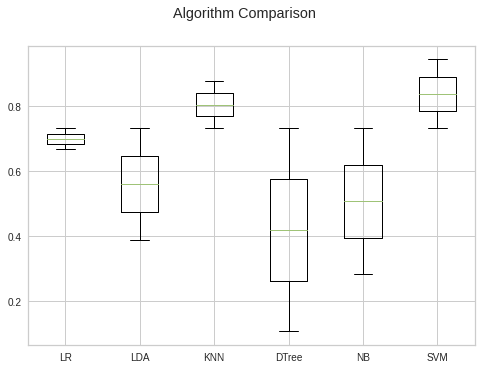

In [65]:
# Compare Algorithms
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=2)
	cv_results = model_selection.cross_val_score(model,X,y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

#Feature Scaling

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Gaussian Naive Bayes classifier

**Gaussian NB is based on the Naive Bayes theorem with the assumption of conditional independence between every pair of features given the label of the target class. The Graph for the likelihood of the feature vectors is Gaussian.**

![Gaussian Naive Bayes classifier](https://www.codespeedy.com/wp-content/uploads/2019/12/iris_gaussian.png)




[[1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [2 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 2]
 [2 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [2 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [2 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [0 0]
 [0 0]

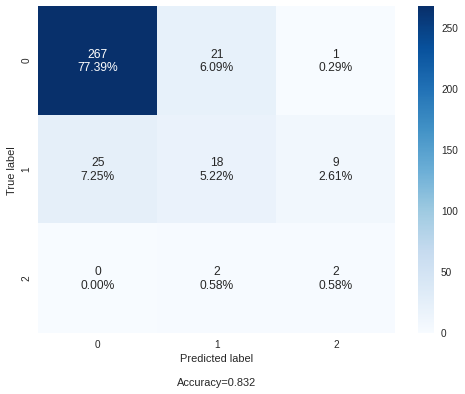

In [68]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

#Logistic Regression 

**Logistic Regression is one of the basic and powerful classifiers used in the machine learning model used for binary as well as multiclass classification problems. Let us apply logistic regression in the same way as we have applied the GaussianNB on the Iris dataset that we have and will be printing the accuracy score for this model as well.**


[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 2]
 [1 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [2 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]

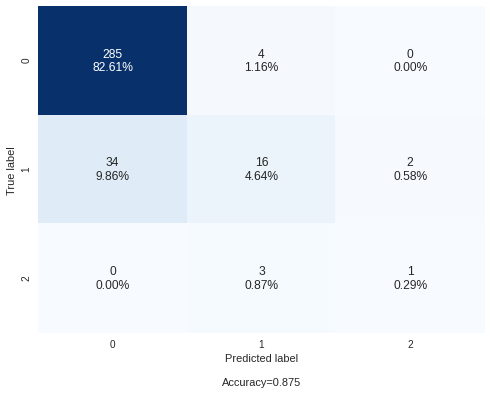

In [86]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6), cbar=False)

#Decision tree classifier 
**Decision Tree classifier is a widely used classification technique where several conditions are put on the dataset in a hierarchical manner until the data corresponding to the labels is purely separated.**



[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 2]
 [1 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [2 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]

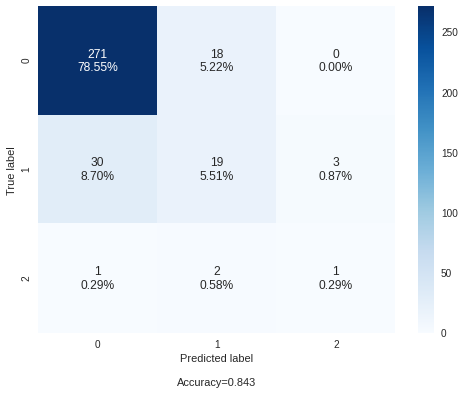

In [87]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

#KNN (k-nearest neighbors) classifier 

 KNN classifier is a very simple technique for classification and it is based upon the Euclidean distance between two data points calculated by taking the distance between the feature vector.
In case of the same distance between a data point and data points belonging to two or more different classes then, the next lowest distance is calculated and it is assumed that the data point will belong to that class. The formula to calculate Euclidean distance between two data points is:

![](https://www.codespeedy.com/wp-content/uploads/2019/12/iris_euclidean.png)

[[1 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 2]
 [1 2]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]

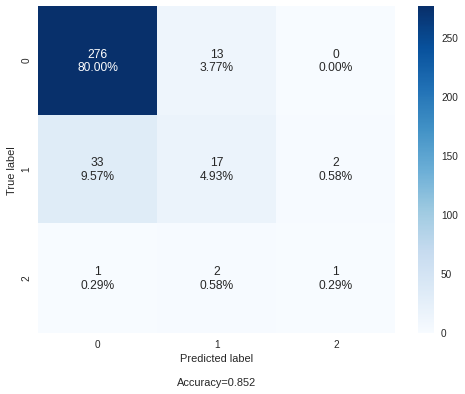

In [91]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 2]
 [1 2]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [2 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]

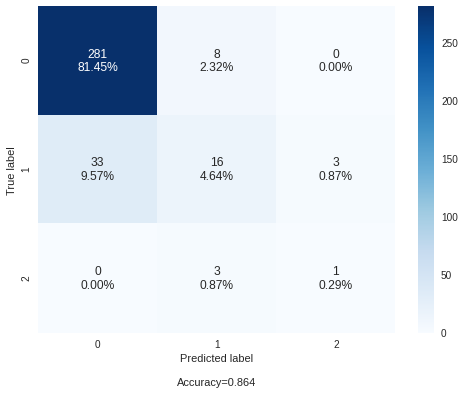

In [72]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

#Support Vector Machine
Support Vector Machine or SVM is a classifier that classifies the data points into the classes(Supervised Learning) and separates those classes using a hyperplane.


[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 2]
 [1 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [2 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]

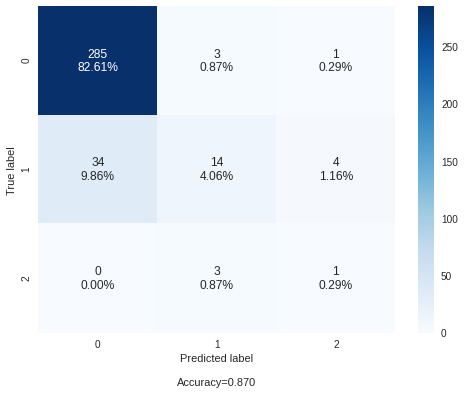

In [73]:
classifier = SVC(C=50,kernel='linear',gamma=1)     
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

# Random Forest Classifier 


[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 2]
 [1 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]

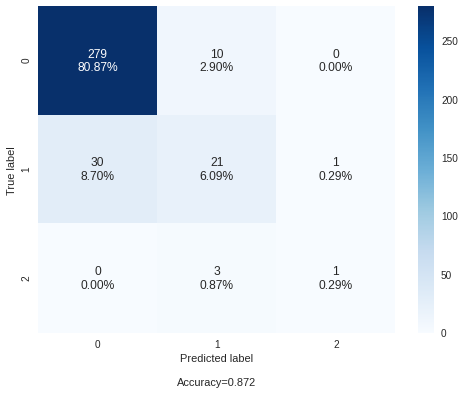

In [93]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

#SVM Multiclassification Model

In [75]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=56)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1032, 11) (1032,)
(345, 11) (345,)


In [76]:
scaler = StandardScaler()
print(scaler.fit(X_train))
StandardScaler()
print(scaler.mean_)
print(scaler.transform(X_train))

StandardScaler(copy=True, with_mean=True, with_std=True)
[1.55482897e+04 3.21017442e+01 1.84205426e+00 4.28982558e+01
 1.57945736e-01 7.61094331e+02 8.13953488e-02 2.08139535e+00
 4.45736434e-02 5.90116279e-01 3.65310078e-01]
[[ 0.56754843 -1.27185907  1.06271018 ... -0.21599339 -1.19988179
   1.3181049 ]
 [-0.40708311  1.93733056 -1.69055402 ... -0.21599339  0.83341543
  -0.75866496]
 [-0.55382251 -0.36060769  0.14495545 ... -0.21599339 -1.19988179
   1.3181049 ]
 ...
 [-0.51793864 -1.11338057  1.06271018 ... -0.21599339 -1.19988179
   1.3181049 ]
 [ 0.45989682 -0.95490207  1.06271018 ... -0.21599339 -1.19988179
   1.3181049 ]
 [ 0.52589751 -1.11338057  1.06271018 ... -0.21599339 -1.19988179
   1.3181049 ]]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[[2 1]
 [0 0]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [2 0]
 [0 0]
 [2 0]
 [0 0]
 [2 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [2 0]
 [0 0]
 [2 1]
 [0 0]
 [0 0]
 [2 1]
 [2 1]
 [2 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 2]
 [2 2]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [2 1]
 [2 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [0 0]
 [0 0]
 [2 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [2 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [2 1]
 [2 0]
 [2 1]
 [0 0]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [2 1]
 [2 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [2 0]
 [0 0]
 [2 1]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [2 0]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [2 1]
 [0 0]
 [0 0]

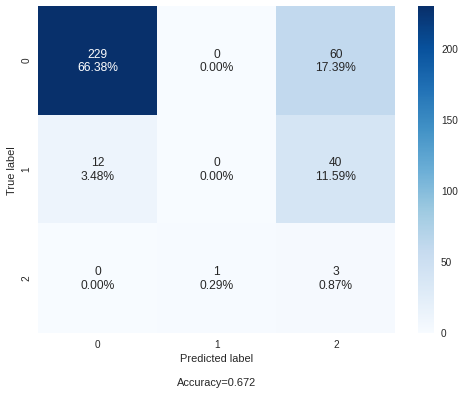

In [98]:
clf = LinearSVC(C=100,tol=1e-5,max_iter=1200000)
svm_mul_class_model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

In [78]:
print('Accuracy of SVM classifier on training set: {:.2f}'
       .format(svm_mul_class_model.score(X_train, y_train)))

Accuracy of SVM classifier on training set: 0.88


In [79]:
print('Accuracy of SVM classifier on test set: {:.2f}'
       .format(svm_mul_class_model.score(X_test[X_train.columns], y_test)))

Accuracy of SVM classifier on test set: 0.86


#XGBoost Multiclassification Model

In [0]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 2]
 [1 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]

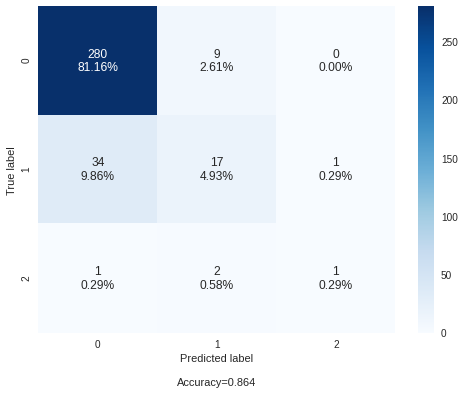

In [85]:
y_pred = ltv_xgb_model.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
make_confusion_matrix(cm, figsize=(8,6))

In [82]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))

Accuracy of XGB classifier on training set: 0.98


In [83]:
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on test set: 0.86


##We can identify that by looking at classification report:

Precision and recall are acceptable for 0. As an example, for cluster 0 (Low LTV), if model tells us this customer belongs to cluster 0, 90 out of 100 will be correct (precision). And the model successfully identifies 93% of actual cluster 0 customers (recall). We really need to improve the model for other clusters. For example, we barely detect 56% of Mid LTV customers. Possible actions to improve those points:

    Adding more features and improve feature engineering
    Try different models other than XGBoost
    Apply hyper parameter tuning to current model
    Add more data to the model if possible